In [1]:
#Import các thư viện cần thiết 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
from statsmodels.formula.api import ols 
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

<h1>1. Tổng quan dữ liệu</h1>

In [2]:
#Lấy dữ liệu và đọc 10 dữ liệu đầu
data = pd.read_csv('Data/laptop_prices.csv')
data.head(5)

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


<h2>Mô tả tập dữ liệu </h2>

- Company: Nhà sản xuất laptop.
- Product: Thương hiệu và mẫu mã của laptop.
- TypeName: Loại laptop (Notebook, Ultrabook, Gaming,...).
- Inches: Kích thước màn hình (inch).
- Ram: Tổng dung lượng RAM của laptop (GB).
- OS: Hệ điều hành được cài đặt.
- Weight: Trọng lượng của laptop (kg).
- Price_euros: Giá của laptop tính theo Euro (Mục tiêu dự đoán).
- Screen: Độ phân giải màn hình (Standard, Full HD, 4K Ultra HD, Quad HD+).
- ScreenW: Chiều rộng của màn hình (pixel).
- ScreenH: Chiều cao của màn hình (pixel).
- Touchscreen: Có màn hình cảm ứng hay không.
- IPSpanel: Có tấm nền IPS hay không.
- RetinaDisplay: Có màn hình Retina hay không.
- CPU_company: Hãng sản xuất CPU.
- CPU_freq: Tần số của CPU (Hz).
- CPU_model: Mô hình CPU.
- PrimaryStorage: Dung lượng bộ nhớ chính (GB).
- PrimaryStorageType: Loại bộ nhớ chính (HDD, SSD, Flash Storage, Hybrid).
- SecondaryStorage: Dung lượng bộ nhớ phụ (nếu có) (GB).
- SecondaryStorageType: Loại bộ nhớ phụ (HDD, SSD, Hybrid, None).
- GPU_company: Hãng sản xuất GPU.
- GPU_model: Mô hình GPU.

In [3]:
#Tính toán thống kê cho các cột số DataFrame 
data.describe()

,Inches,Ram,Weight,Price_euros,ScreenW,ScreenH,CPU_freq,PrimaryStorage,SecondaryStorage
count,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000,1275.000000
mean,15.022902,8.440784,2.040525,1134.969059,1900.043922,1073.904314,2.302980,444.517647,176.069020
std,1.429470,5.097809,0.669196,700.752504,493.346186,283.883940,0.503846,365.537726,415.960655
min,10.100000,2.000000,0.690000,174.000000,1366.000000,768.000000,0.900000,8.000000,0.000000
25%,14.000000,4.000000,1.500000,609.000000,1920.000000,1080.000000,2.000000,256.000000,0.000000
50%,15.600000,8.000000,2.040000,989.000000,1920.000000,1080.000000,2.500000,256.000000,0.000000
75%,15.600000,8.000000,2.310000,1496.500000,1920.000000,1080.000000,2.700000,512.000000,0.000000
max,18.400000,64.000000,4.700000,6099.000000,3840.000000,2160.000000,3.600000,2048.000000,2048.000000


Nhận xét : 
+ Inches (Kích thước màn hình):
    - Kích thước màn hình trung bình là 15.02 inch, với độ lệch chuẩn khoảng 1.43 inch.
    - Màn hình nhỏ nhất là 10.1 inch và lớn nhất là 18.4 inch.
    - Phân bố kích thước màn hình khá đồng đều với 50% giá trị dưới mức 15.6 inch.
+ Ram (Dung lượng RAM):
    - Dung lượng RAM trung bình là 8.44 GB, với độ lệch chuẩn 5.1 GB.
    - Dung lượng RAM nhỏ nhất là 2 GB và lớn nhất lên đến 64 GB.
    - Đa phần laptop có dung lượng RAM từ 4 GB (25%) đến 8 GB (75%).
+ Weight (Trọng lượng laptop):
    - Trọng lượng trung bình của laptop là 2.04 kg, với độ lệch chuẩn là 0.67 kg.
    - Laptop nhẹ nhất có trọng lượng 0.69 kg, và laptop nặng nhất là 4.7 kg.
    - 50% số laptop có trọng lượng khoảng 2.04 kg hoặc ít hơn.
+ Price_euros (Giá laptop):
    - Giá trung bình của laptop là 1134.97 Euro, với độ lệch chuẩn khá lớn, 700.75 Euro.
    - Giá thấp nhất là 174 Euro và cao nhất là 6099 Euro.
    - 50% số laptop có giá dưới 989 Euro, cho thấy giá cả biến thiên khá lớn.
+ ScreenW (Chiều rộng màn hình - pixel):
    - Chiều rộng màn hình trung bình là 1900.04 pixel.
    - Màn hình nhỏ nhất có chiều rộng 1366 pixel, và lớn nhất là 3840 pixel (độ phân giải 4K).
    - Đa số các laptop có chiều rộng màn hình 1920 pixel (Full HD).
+ ScreenH (Chiều cao màn hình - pixel):
    - Chiều cao màn hình trung bình là 1073.9 pixel, với độ lệch chuẩn 283.88 pixel.
    - Màn hình thấp nhất có 768 pixel, và màn hình cao nhất là 2160 pixel (độ phân giải 4K).
    - 50% số laptop có chiều cao màn hình là 1080 pixel (Full HD).
+ CPU_freq (Tần số CPU):
    - Tần số CPU trung bình là 2.30 GHz, với độ lệch chuẩn 0.5 GHz.
    - Tần số nhỏ nhất là 0.9 GHz, trong khi lớn nhất đạt 3.6 GHz.
    - Phân bố tần số khá đồng đều, với đa số CPU trong khoảng từ 2.0 GHz đến 2.7 GHz.
+ PrimaryStorage (Dung lượng bộ nhớ chính):
    - Dung lượng bộ nhớ chính trung bình là 444.52 GB, với độ lệch chuẩn 365.54 GB.
    - Laptop có bộ nhớ nhỏ nhất là 8 GB và lớn nhất là 2048 GB (2 TB).
    - 50% số laptop có dung lượng bộ nhớ chính dưới 256 GB.
+ SecondaryStorage (Dung lượng bộ nhớ phụ):
    - Bộ nhớ phụ trung bình là 176.07 GB, nhưng có độ lệch chuẩn rất lớn là 415.96 GB.
    - Nhiều laptop không có bộ nhớ phụ (giá trị 0), trong khi một số có dung lượng lớn lên tới 2048 GB (2 TB).
    - 75% số laptop có dung lượng bộ nhớ phụ bằng 0, nghĩa là phần lớn laptop chỉ có một bộ nhớ chính.

In [4]:
#Tính toán thống kê cho các cột danh mục 
data.describe(include='O')

,Company,Product,TypeName,OS,Screen,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_model,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
count,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275
unique,19,618,6,9,4,2,2,2,3,93,4,4,4,110
top,Dell,XPS 13,Notebook,Windows 10,Full HD,No,No,No,Intel,Core i5 7200U,SSD,No,Intel,HD Graphics 620
freq,291,30,707,1048,835,1087,918,1258,1214,193,837,1067,704,279


+ Company (Nhà sản xuất):
    - Có tổng cộng 19 hãng sản xuất khác nhau.
    - Hãng Dell xuất hiện nhiều nhất với tần suất 291 lần.
+ Product (Thương hiệu và mẫu mã):
    - Tổng cộng có 618 mẫu mã khác nhau.
    - Mẫu XPS 13 của Dell là phổ biến nhất, xuất hiện 30 lần.
+ TypeName (Loại laptop):
    - Có 6 loại laptop khác nhau.
    - Notebook là loại phổ biến nhất với 707 mẫu, chiếm hơn một nửa số lượng.
+ OS (Hệ điều hành):
    - Có 9 loại hệ điều hành khác nhau.
    - Windows 10 là hệ điều hành phổ biến nhất, chiếm 1048 laptop (phần lớn).
+ Screen (Độ phân giải màn hình):
    - Có 4 loại độ phân giải màn hình khác nhau.
    - Full HD là loại phổ biến nhất với 835 lần xuất hiện.
+ Touchscreen (Màn hình cảm ứng):
    - Có 2 giá trị (có hoặc không).
    - Phần lớn laptop không có màn hình cảm ứng, với tần suất 1087 lần.
+ IPSpanel (Tấm nền IPS):
    - Có 2 giá trị (có hoặc không).
    - Phần lớn laptop không có tấm nền IPS, với 918 trường hợp.
+ RetinaDisplay (Màn hình Retina):
    - Có 2 giá trị (có hoặc không).
    - 1258 laptop không có màn hình Retina, cho thấy rất ít laptop sử dụng loại màn hình này.
+ CPU_company (Hãng sản xuất CPU):
    - Có 3 hãng sản xuất CPU khác nhau.
    - Intel là hãng sản xuất CPU phổ biến nhất, chiếm 1214 trường hợp.
+ CPU_model (Mô hình CPU):
    - Có tổng cộng 93 mẫu CPU khác nhau.
    - Mô hình Core i5 7200U là phổ biến nhất với 193 laptop sử dụng.
+ PrimaryStorageType (Loại bộ nhớ chính):
    - Có 4 loại bộ nhớ chính.
    - SSD là loại bộ nhớ chính phổ biến nhất, với 837 laptop sử dụng.
+ SecondaryStorageType (Loại bộ nhớ phụ):
    - Có 4 loại bộ nhớ phụ.
    - Phần lớn laptop không có bộ nhớ phụ (tần suất là 1067).
+ GPU_company (Hãng sản xuất GPU):
    - Có 4 hãng sản xuất GPU khác nhau.
    - Intel là hãng sản xuất GPU phổ biến nhất, với 704 laptop sử dụng GPU của hãng.
+ GPU_model (Mô hình GPU):
    - Có tổng cộng 110 mẫu GPU khác nhau.
    - Mô hình HD Graphics 620 của Intel là phổ biến nhất, xuất hiện 279 lần.

<h1>2. Xử lý dữ liệu</h1>

<h2>2.1 Xử lý dữ liệu trùng lặp</h2>

In [5]:
data[data.duplicated()].sort_values(by='Product')

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model


**Nhận xét**: Dữ liệu không có trùng lặp trong bộ dữ liệu

<h2>2.2 Kiểm tra dữ liệu lỗi cấu trúc</h2>

In [6]:
#Tổng quan DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   Product               1275 non-null   object 
 2   TypeName              1275 non-null   object 
 3   Inches                1275 non-null   float64
 4   Ram                   1275 non-null   int64  
 5   OS                    1275 non-null   object 
 6   Weight                1275 non-null   float64
 7   Price_euros           1275 non-null   float64
 8   Screen                1275 non-null   object 
 9   ScreenW               1275 non-null   int64  
 10  ScreenH               1275 non-null   int64  
 11  Touchscreen           1275 non-null   object 
 12  IPSpanel              1275 non-null   object 
 13  RetinaDisplay         1275 non-null   object 
 14  CPU_company           1275 non-null   object 
 15  CPU_freq             

In [7]:
column_check = data.drop(['Inches','Product','Ram','Weight','Price_euros','ScreenW','ScreenH','CPU_freq','PrimaryStorage','SecondaryStorage'],axis=1)
for i in column_check:
    print(f'Các giá trị trong cột {i} là : {data[i].unique()}')

Các giá trị trong cột Company là : ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']
Các giá trị trong cột TypeName là : ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']
Các giá trị trong cột OS là : ['macOS' 'No OS' 'Windows 10' 'Mac OS X' 'Linux' 'Android' 'Windows 10 S'
 'Chrome OS' 'Windows 7']
Các giá trị trong cột Screen là : ['Standard' 'Full HD' 'Quad HD+' '4K Ultra HD']
Các giá trị trong cột Touchscreen là : ['No' 'Yes']
Các giá trị trong cột IPSpanel là : ['Yes' 'No']
Các giá trị trong cột RetinaDisplay là : ['Yes' 'No']
Các giá trị trong cột CPU_company là : ['Intel' 'AMD' 'Samsung']
Các giá trị trong cột CPU_model là : ['Core i5' 'Core i5 7200U' 'Core i7' 'A9-Series 9420' 'Core i7 8550U'
 'Core i5 8250U' 'Core i3 6006U' 'Core M m3' 'Core i7 7500U'
 'Core i3 7100U' 'Atom x5-Z8350' 'Core i5 7300HQ' 'E-Series E2-9000e'
 'Core i7 8650U' '

Nhận xét : Các cột Object không chứa dữ liệu khác thường 

<h2>2.3 Xử lý dữ liệu thiếu (missing data)</h2>

In [8]:
#Kiểm tra missing 
print('Tổng dữ liệu bị thiếu:','\n',data.isnull().sum())

Tổng dữ liệu bị thiếu: 
 Company                 0
Product                 0
TypeName                0
Inches                  0
Ram                     0
OS                      0
Weight                  0
Price_euros             0
Screen                  0
ScreenW                 0
ScreenH                 0
Touchscreen             0
IPSpanel                0
RetinaDisplay           0
CPU_company             0
CPU_freq                0
CPU_model               0
PrimaryStorage          0
SecondaryStorage        0
PrimaryStorageType      0
SecondaryStorageType    0
GPU_company             0
GPU_model               0
dtype: int64


**Nhận xét**: Không có dữ liệu nào bị thiếu 

<h2>2.4 Xử lý ngoại lệ</h2>

In [9]:
name_list = ['Inches','Ram','Weight','Price_euros','ScreenW','ScreenH','CPU_freq','PrimaryStorage','SecondaryStorage']

def z_score_del(df, a):
    # Tính z-score cho cột 
    name_column = a + '_zscore'
    df[name_column] = stats.zscore(df[a])
    
    # Lưu giá trị ngoại lai vào một DataFrame mới
    outliers = df[(df[name_column] > 3) | (df[name_column] < -3)]
    
    # Xóa bỏ ngoại lệ và xóa bỏ cột điểm z-score 
    df.drop(df[(df[name_column] > 3) |  (df[name_column] < -3)].index, inplace=True)
    df.drop(name_column, axis=1, inplace=True)
    
    # Hiển thị giá trị ngoại lai
    print(f"Outliers in {a}:\n", outliers)
    
    return df

# Sử dụng hàm
for i in name_list:
    data = z_score_del(data, i)


Outliers in Inches:
      Company    Product            TypeName  Inches  Ram          OS  Weight  \
50    Lenovo  Yoga Book  2 in 1 Convertible    10.1    4     Android    0.69   
1082  Lenovo  Yoga Book  2 in 1 Convertible    10.1    4  Windows 10    0.69   
1114  Lenovo  Yoga Book  2 in 1 Convertible    10.1    4     Android    0.69   
1126  Lenovo  Yoga Book  2 in 1 Convertible    10.1    4  Windows 10    0.69   

      Price_euros    Screen  ScreenW  ...  CPU_company CPU_freq  \
50         319.00  Standard     1920  ...        Intel     1.44   
1082       646.27  Standard     1920  ...        Intel     1.44   
1114       549.00  Standard     1920  ...        Intel     1.44   
1126       479.00  Standard     1920  ...        Intel     1.44   

          CPU_model PrimaryStorage SecondaryStorage  PrimaryStorageType  \
50    Atom x5-Z8550             64                0       Flash Storage   
1082  Atom x5-Z8550             64                0       Flash Storage   
1114  Atom x5-Z85

# 3 Xây dựng mô hình dự đoán

## 3.1 Label encoding: One hot encoding  

In [10]:
data_clean = data.drop(['Product','CPU_model','GPU_model','Company'],axis =1)
data_clean

,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,ScreenH,Touchscreen,IPSpanel,RetinaDisplay,CPU_company,CPU_freq,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company
0,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,1600,No,Yes,Yes,Intel,2.3,128,0,SSD,No,Intel
1,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,900,No,No,No,Intel,1.8,128,0,Flash Storage,No,Intel
2,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,1080,No,No,No,Intel,2.5,256,0,SSD,No,Intel
4,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,1600,No,Yes,Yes,Intel,3.1,256,0,SSD,No,Intel
5,Notebook,15.6,4,Windows 10,2.10,400.00,Standard,1366,768,No,No,No,AMD,3.0,500,0,HDD,No,AMD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Notebook,15.6,4,Windows 10,2.20,720.32,Standard,1366,768,No,No,No,Intel,2.5,500,0,HDD,No,Nvidia
1270,2 in 1 Convertible,14.0,4,Windows 10,1.80,638.00,Full HD,1920,1080,Yes,Yes,No,Intel,2.5,128,0,SSD,No,Intel
1272,Notebook,14.0,2,Windows 10,1.50,229.00,Standard,1366,768,No,No,No,Intel,1.6,64,0,Flash Storage,No,Intel
1273,Notebook,15.6,6,Windows 10,2.19,764.00,Standard,1366,768,No,No,No,Intel,2.5,1024,0,HDD,No,AMD


In [11]:
#One hot encoding 
string_columns = data_clean.select_dtypes(include=['object']).columns

data_one_hot = pd.get_dummies(data_clean, columns = list(string_columns), dtype=float)
data_one_hot.columns = data_one_hot.columns.str.replace(' ','_')
data_one_hot.rename(columns={'Screen_Quad_HD+':'Screen_Quad_Plus'},inplace=True)
data_one_hot

,Inches,Ram,Weight,Price_euros,ScreenW,ScreenH,CPU_freq,PrimaryStorage,SecondaryStorage,TypeName_2_in_1_Convertible,...,PrimaryStorageType_HDD,PrimaryStorageType_Hybrid,PrimaryStorageType_SSD,SecondaryStorageType_HDD,SecondaryStorageType_No,SecondaryStorageType_SSD,GPU_company_AMD,GPU_company_ARM,GPU_company_Intel,GPU_company_Nvidia
0,13.3,8,1.37,1339.69,2560,1600,2.3,128,0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,13.3,8,1.34,898.94,1440,900,1.8,128,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,15.6,8,1.86,575.00,1920,1080,2.5,256,0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,13.3,8,1.37,1803.60,2560,1600,3.1,256,0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,15.6,4,2.10,400.00,1366,768,3.0,500,0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,15.6,4,2.20,720.32,1366,768,2.5,500,0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1270,14.0,4,1.80,638.00,1920,1080,2.5,128,0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1272,14.0,2,1.50,229.00,1366,768,1.6,64,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1273,15.6,6,2.19,764.00,1366,768,2.5,1024,0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## 3.2 Lựa chọn đặc trưng - Forward Selection

In [12]:
X = data_one_hot.drop(['Price_euros'],axis=1)
y = data_one_hot['Price_euros']

In [13]:
lreg = LinearRegression()
sfs1 = sfs(lreg, k_features='best', forward=True, verbose=2, scoring='neg_mean_squared_error')
sfs1 = sfs1.fit(X,y)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s

[2024-10-24 18:00:12] Features: 1/45 -- score: -169058.72760230227[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s

[2024-10-24 18:00:12] Features: 2/45 -- score: -138755.0298558156[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s

[2024-10-24 18:00:12] Features: 3/45 -- score: -124629.39503333015[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s

[2024-10-24 18:00:12] Features: 4/45 -- score: -114282.16440398051[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s

[2024-10-24 18:00:13] Features: 5/45 -- score: -106846.52252982976[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s

[2024-10-24 18:00:13] Features: 6/45 -- score: -101858.10663645683
[2024-10-24 18:00:13] Features: 7/45 -- score: -98030.95023701126
[2024-10-24 18:00:13] Features: 8/45 -- score: -94723.38260197142
[2024-10-24 18:00:14] Features: 9/45 --

In [14]:
#Hiển thị các Feature tốt nhất cho mô hình 
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

['Ram', 'Weight', 'ScreenW', 'ScreenH', 'CPU_freq', 'TypeName_Gaming', 'TypeName_Notebook', 'TypeName_Ultrabook', 'TypeName_Workstation', 'OS_No_OS', 'OS_Windows_10', 'OS_Windows_7', 'OS_macOS', 'Screen_Full_HD', 'Screen_Standard', 'CPU_company_Intel', 'PrimaryStorageType_HDD', 'PrimaryStorageType_SSD', 'SecondaryStorageType_HDD', 'GPU_company_Intel']


## 3.3 Xây dựng mô hình

In [22]:
#Chia dữ liệu thành tập train-test
X = data_one_hot.drop('Price_euros',axis=1)
y = data_one_hot['Price_euros']
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [16]:
# Xây dựng công thức OLS
ols_formula = 'Price_euros ~ '
for i in feat_names:
    ols_formula +=  i + ' + '
# In ra công thức OLS
ols_formula = ols_formula.rstrip(' + ')
print(ols_formula)

Price_euros ~ Ram + Weight + ScreenW + ScreenH + CPU_freq + TypeName_Gaming + TypeName_Notebook + TypeName_Ultrabook + TypeName_Workstation + OS_No_OS + OS_Windows_10 + OS_Windows_7 + OS_macOS + Screen_Full_HD + Screen_Standard + CPU_company_Intel + PrimaryStorageType_HDD + PrimaryStorageType_SSD + SecondaryStorageType_HDD + GPU_company_Intel


In [17]:
ols_data = pd.concat([X_train,y_train],axis=1)

OLS = ols(formula= ols_formula, data=ols_data)
model = OLS.fit()

In [18]:
#Hiển thị kết quả 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Price_euros   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     115.1
Date:                Thu, 24 Oct 2024   Prob (F-statistic):          3.49e-215
Time:                        18:00:42   Log-Likelihood:                -5555.2
No. Observations:                 789   AIC:                         1.115e+04
Df Residuals:                     768   BIC:                         1.125e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1602.8805    257.111     -6.234      0.000   -2107.605   -1098.156
Ram                         61.7710      3.723     16.591      0.000      54.462      69.080
Weight                    -100.6117     32.107     -3.134      0.002    -163.639     -37.584
ScreenW                      0.8872      0.291      3.054      0.002       0.317       1.458
ScreenH                     -0.5751      0.445     -1.292      0.197      -1.449       0.298
CPU_freq                   240.2376     24.336      9.872      0.000     192.464     288.011
TypeName_Gaming            -21.6429     60.298     -0.359      0.720    -140.012      96.726
TypeName_Notebook         -188.4193     38.569     -4.885      0.000    -264.133    -112.705
TypeName_Ultrabook         113.6570     42.804      2.655      0.008      29.631     197.683
TypeName_Workstation       530.1606     87.933      6.029      0.000     357.543     702.778
OS_No_OS                   -66.3945     58.240     -1.140      0.255    -180.724      47.935
OS_Windows_10              140.1325     42.067      3.331      0.001      57.552     222.713
OS_Windows_7               377.4825     68.370      5.521      0.000     243.268     511.697
OS_macOS                   -70.7364    119.983     -0.590      0.556    -306.270     164.797
Screen_Full_HD             218.8014    169.733      1.289      0.198    -114.394     551.997
Screen_Standard            460.8042    180.520      2.553      0.011     106.432     815.176
CPU_company_Intel          272.6678     49.553      5.503      0.000     175.392     369.943
PrimaryStorageType_HDD      72.1098     51.224      1.408      0.160     -28.447     172.666
PrimaryStorageType_SSD     204.3323     50.029      4.084      0.000     106.122     302.542
SecondaryStorageType_HDD   130.1437     45.152      2.882      0.004      41.508     218.779
GPU_company_Intel           75.3483     29.138      2.586      0.010      18.149     132.548
==============================================================================
Omnibus:                      105.967   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.600
Skew:                           0.859   Prob(JB):                     1.65e-39
Kurtosis:                       4.576   Cond. No.                     7.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- R-square = 0.75 : Điều này cho thấy khoảng 75% biến thiên của biến phụ thuộc có thể được giải thích bởi các biến độc lập trong mô hình. Giá trị gần 1 cho thấy mô hình có độ khớp tốt. - Intercept : Nếu tất cả các biến đều bằng 0 , giá trị dự đoán của biến phụ thuộc sẽ là -1602.880
- Chỉ số coef , ví dụ của Ram cho thấy nếu chỉ số Ram tăng thêm 1 đơn vị thì giá tiền sẽ tăng 61,7710 Euro dựa trên dữ liệu, điều này cũng tương tự như các giá trị khá
- Chỉ số P>|t|: cho thấy giá trị p-value của từng biến , nếu nhỏ hơn 0.05 thì biến đó có ý nghĩa thống kê qua kết quả thu được ta có thể thấy : RAM , CPU_feq, loại laptop và hệ điều hành có ảnh hưởng đáng kể đến 
- 	Tuy nhiên cũng có một số biến như ScreenH , OS_NO_OS, Type_Name_Gaming không có ý nghĩa thống kê, cho thấy chúng không ảnh hưởng nhiều đến giá của laptop.
-----------------
***Kết luận : có thể nói đây là một mô hình khi dự đoán đúng 75%***

# 4 Kiểm tra giả định 

## 4.1 Kiểm tra tính tuyến tính

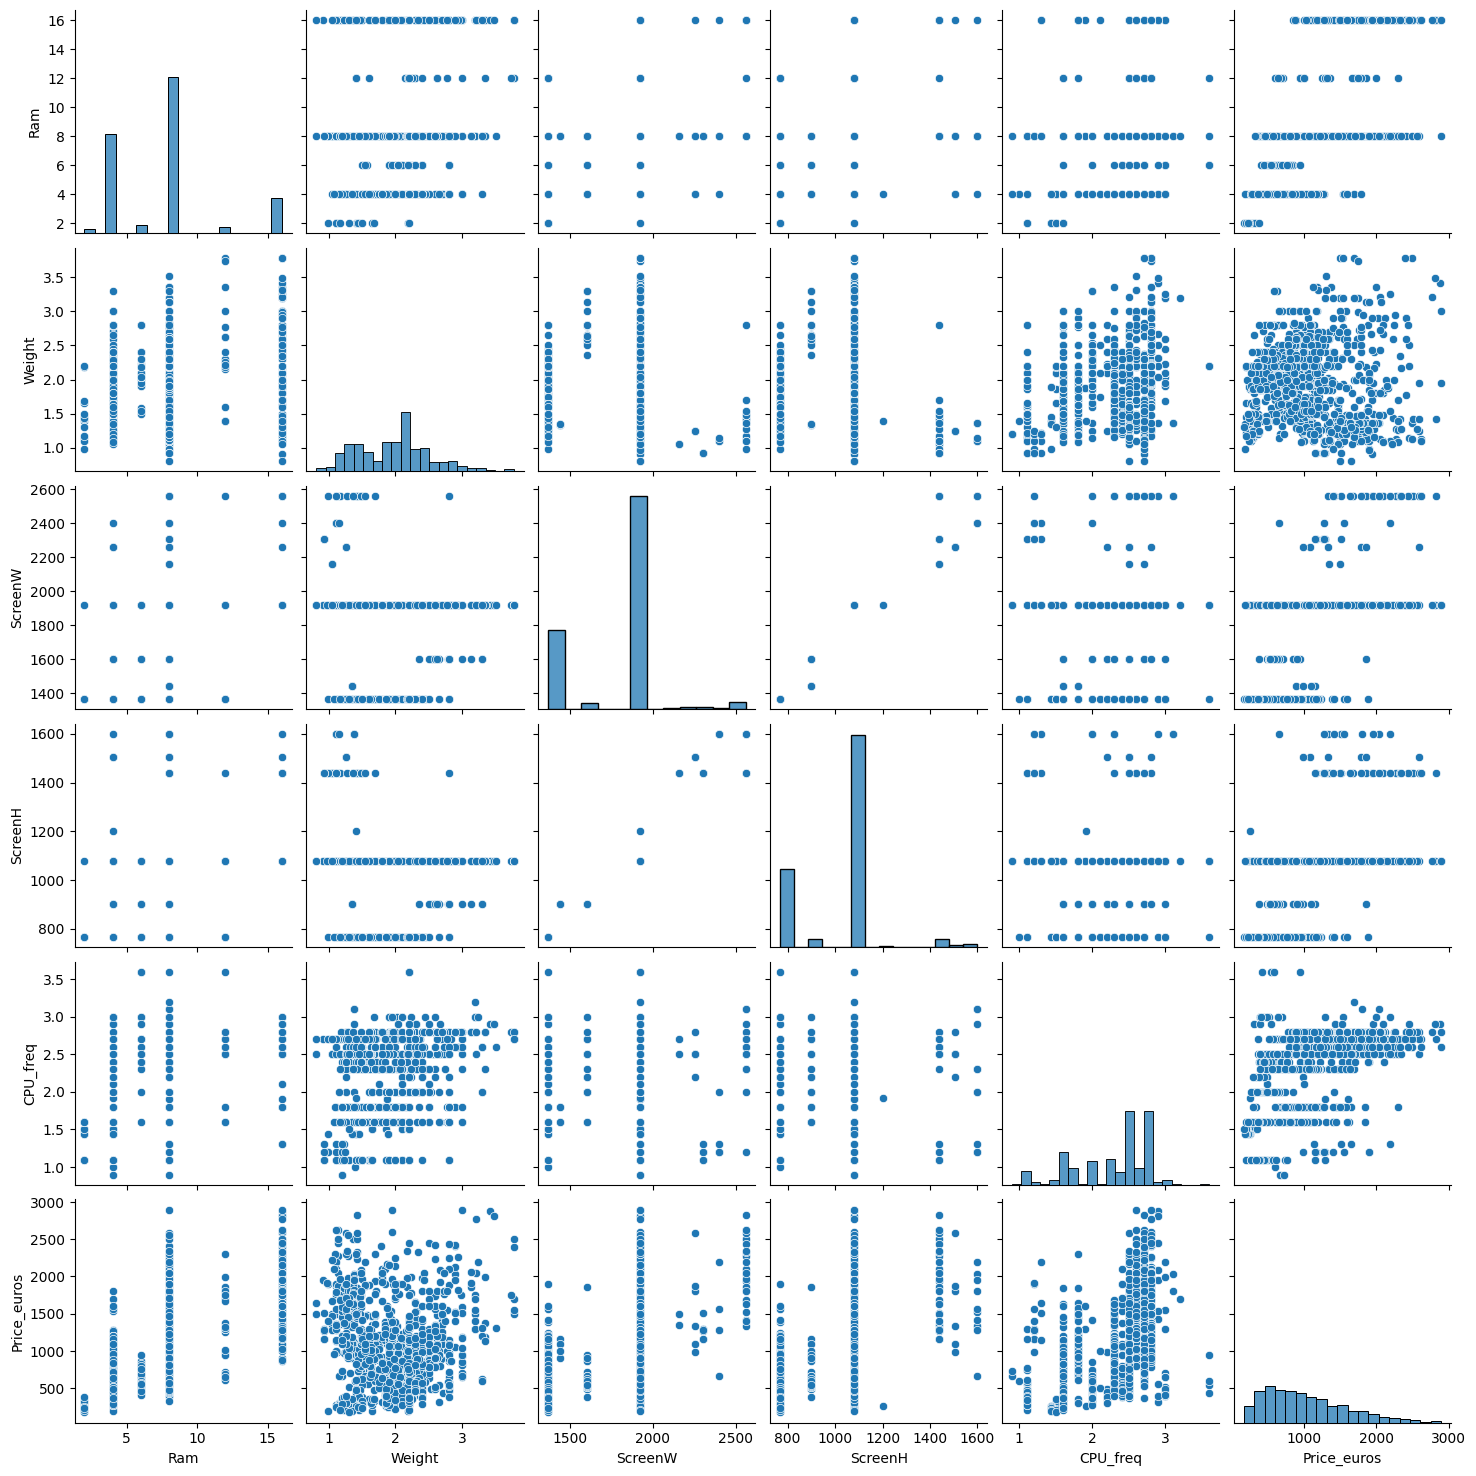

In [26]:
sns.pairplot(data[['Ram', 'Weight', 'ScreenW', 'ScreenH', 'CPU_freq','Price_euros']])
plt.show()

Nhận xét :
- Ram và giá: Có vẻ như khi dung lượng RAM tăng thì giá cũng có xu hướng tăng, tuy nhiên mối quan hệ này không hoàn toàn tuyến tính và có khá nhiều điểm dữ liệu phân tán.
- Weight và giá: Mối quan hệ giữa trọng lượng và giá không rõ ràng, có thể có một xu hướng giảm nhẹ khi trọng lượng tăng nhưng sự phân tán dữ liệu rất lớn.
- ScreenW và giá: Có vẻ như chiều rộng màn hình có ảnh hưởng đến giá, tuy nhiên mối quan hệ này cũng không hoàn toàn tuyến tính và có nhiều điểm dữ liệu phân tán.
- ScreenH và giá: Tương tự như chiều rộng màn hình, chiều cao màn hình cũng có thể có ảnh hưởng đến giá nhưng mối quan hệ không rõ ràng.
- CPU_freq và giá: Tần số CPU có vẻ có mối quan hệ tích cực với giá, tức là khi tần số CPU tăng thì giá cũng có xu hướng tăng.

<h2>4.2 Kiểm tra tính chuẩn tắc</h2>

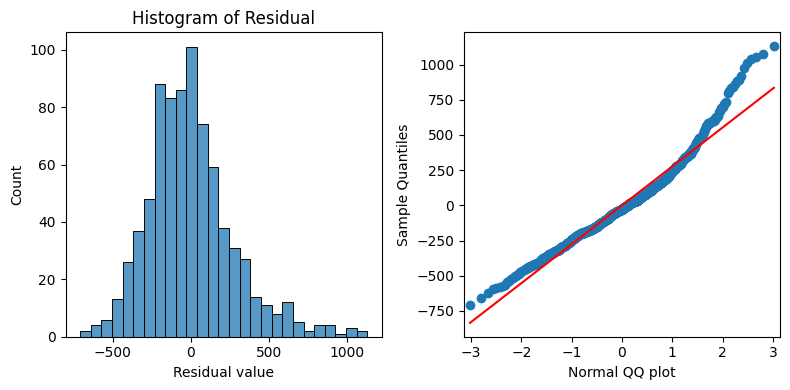

In [27]:
residuals = model.resid

#Create a 1x2 plot figure
fig,axes = plt.subplots(1,2, figsize = (8,4))
#Tạo biểu đồ histogram với residuals
sns.histplot(residuals,ax=axes[0])

axes[0].set_xlabel("Residual value")
axes[0].set_title('Histogram of Residual')

#Create QQ plot of the residual 
sm.qqplot(residuals, line='s',ax = axes[1])
axes[1].set_xlabel('Normal QQ plot')
plt.tight_layout()
plt.show()

- Biểu đồ Histogram :
  + Biểu đồ có hình dạng giống một phân phối chuẩn với phần lớn các giá trị dư tập trung quanh giá trị 0 ,nhưng có vẻ hơi lệch sang phải 
  + Có một số outlier ở bên phải, suy ra có một số điểm dữ liệu có giá trị dự đoán chênh lệch khá lớn so với thực tế
- Biểu đồ QQ của phần dư:
  + Phần lớn các điểm dữ liệu nằm gần đường chéo: Điều này cho thấy dữ liệu có xu hướng tuân theo phân phối chuẩn.
  + Tuy nhiên, có một số điểm ở hai đầu (cả đầu trên và đầu dưới) lệch khá xa khỏi đường thẳng đặc biệt là bên phải: Điều này cho thấy có thể có một số giá trị ngoại lai hoặc đuôi phân phối của dữ liệu có thể hơi dày hơn so với phân phối chuẩn.
- **Kết luận**: Có thể nói rằng dữ liệu có xu hướng tuân theo phân phối chuẩn, nhưng không hoàn toàn tuân theo. Sự lệch của một số điểm ở hai đầu cho thấy cần phải xem xét thêm các yếu tố khác. Ví dụ như xác định nguyên nhân của outlier và xử lý outlier hoặc xem xét sử dụng mô hình khác

<h2>4.3 Kiểm tra tính đồng nhất</h2>

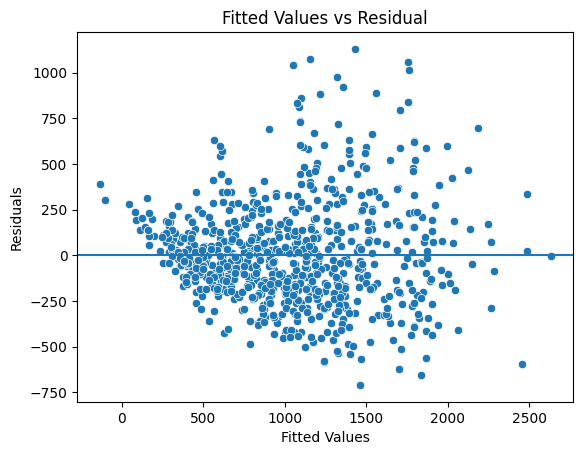

In [28]:
fig = sns.scatterplot(x = model.fittedvalues,y = model.resid)
fig.set_xlabel("Fitted Values")
fig.set_ylabel('Residuals')
fig.set_title("Fitted Values vs Residual")
fig.axhline(0)
plt.show()

- Dựa trên đồ thị, có thể kết luận rằng mô hình có tính đồng nhất tương đối tốt. Điều này nghĩa là giả định về tính đồng nhất của mô hình hồi quy tuyến tính đã được đáp ứng một cách hợp lý.
- Lưu ý : Mô hình có một chút tương đồng với trường hợp Heteroscedasticity , điều này có nghĩa là với những chiếc laptop có giá dự đoán cao , sai số dự đoán cũng có xu hướng lớn hơn so với những chiếc laptop có giá dự đoán thấp 

## 4.4 Kiểm tra tính đa cộng tuyến

   level_0  level_1         0
0   Inches   Weight  0.851257
1   Weight   Inches  0.851257
2  ScreenW  ScreenH  0.985141
3  ScreenH  ScreenW  0.985141


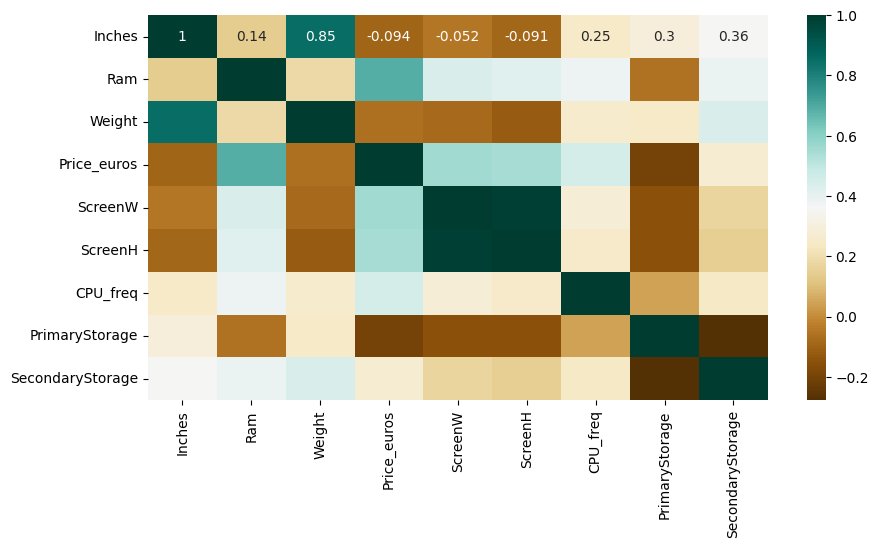

In [29]:
data.corr(method=)

Nhận xét : Dựa vào biểu đồ đa cộng tuyến , có thể thấy cột Inches và cột Weight có tính đa cộng tuyến cao hơn 0.8, tiếp theo là cột ScreenW và cột ScreenH cũng có tính đa cộng tuyến cao hơn 0.8.

**Giải pháp : Loại bỏ một trong hai cột của mỗi cặp trên , ưu tiên giữ lại những cột có ảnh hưởng đến giá trị dự đoán của mô hình** 

# 5 Đánh giá mô hình, kiểm tra overfitting

In [30]:
#Tính chỉ số MSE , MAE , RMSE , R2 
y_pred_lineae = model.predict(X_test)

mae_linear = mean_absolute_error(y_test, y_pred_lineae)
mse_linear = mean_squared_error(y_test, y_pred_lineae)
rmse_linear = mean_squared_error(y_test,y_pred_lineae, squared=False)
r2_linear = r2_score(y_test,y_pred_lineae)

print(f"MAE:{mae_linear} \n MSE:{mse_linear} \n RMSE:{rmse_linear} \n R2:{r2_linear}")

MAE:208.13149772057838 
 MSE:74662.18803714144 
 RMSE:273.2438252497967 
 R2:0.7578144609854505


**Nhận xét** : 
- Giá trị MAE cho thấy trung bình độ lệch giữa giá trị dự đoán và giá trị thực tế rơi vào khoảng 208.131 euros . Có nghĩa là mô hình dự đoán sai lệch trong khoảng 208.13 so với giá thực tế
- Giá trị MSE cho thấy trung bình phương sai số dự báo : 74662.18803714144
- Giá trị RMSE - là căn bậc hai của giá trị MSE : 273.2438252497967
- R^2 ~ 0.7578 điều này có nghĩa 75,78% biến thiên của biến phụ thuộc được giải thích bởi các biến độc lập , đây là một con số cao chứng tỏ mô hình dự đoán hoạt động tốt với dữ liệu này

<h1>Tổng kết</h1>

Dựa trên kết quả phân tích và thử nghiệm mô hình hồi quy đa tuyến tính , mô hình thể hiện khả năng dự đoán tốt với R2 = 0.75 trên mô hình OLS và ~ 0.7578 trên tập test. Mô hình có xu hướng hoạt động ổn định, nhưng vẫn tồn tại một số dự đoán có sai số lớn, có thể liên quan đến các outliers hoặc các yếu tố chưa được mô hình nắm bắt đầy đủ. Nhìn chung, mô hình có tiềm năng áp dụng vào thực tế nhưng vẫn cần cải tiến thêm để nâng cao độ chính xác dự đoán, đặc biệt khi làm việc với những điểm dữ liệu ngoại lệ hoặc các trường hợp đặc biệt.Điều này có nghĩa là chúng ta có thể sử dụng mô hình này để dự đoán được giá laptop dựa trên các đặc điểm kỹ thuật của chúng.